In [121]:
import pandas as pd
import numpy as np
from pymssa import MSSA
import matplotlib.pyplot as plt
import warnings
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings('ignore')

In [3]:
stock = pd.read_csv('./data/TSLA.csv')

In [4]:
stock = stock.iloc[:1000]
stock = stock[['close', 'time']]
stock['time'] = pd.to_datetime(stock['time'])
stock = stock.set_index('time')

In [5]:
temp = pd.read_csv('./data/temp.csv')

In [6]:
temp = temp[['date', 'meantemp']]
temp['date'] = pd.to_datetime(temp['date'])
temp = temp.set_index('date')

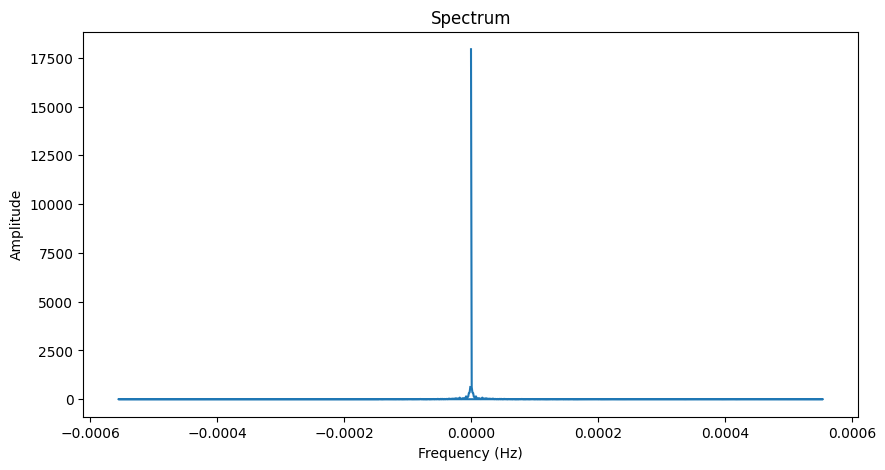

In [7]:
fft_result = np.fft.fft(stock['close'])

# Вычисляем абсолютные значения (для получения мощности)
fft_abs = np.abs(fft_result)

# Вычисляем частоты (в Гц)
freqs = np.fft.fftfreq(len(stock), d=15*60)

# Строим график мощности гармоник
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_abs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum')
plt.show()

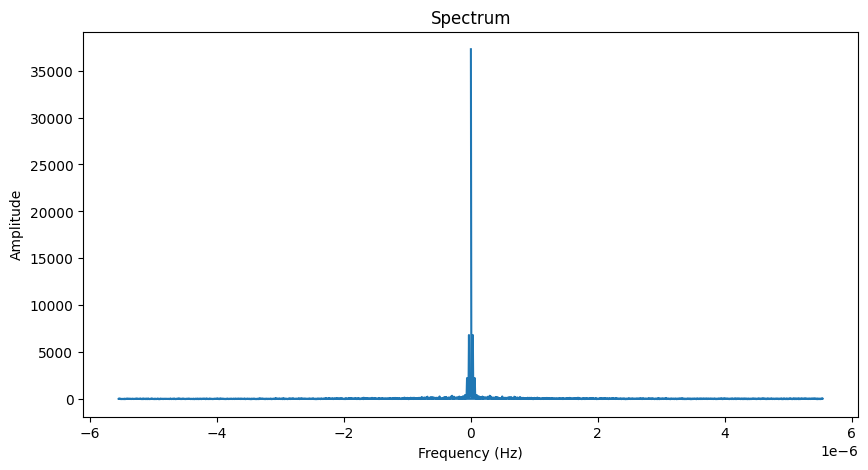

In [8]:
fft_result = np.fft.fft(temp['meantemp'])

# Вычисляем абсолютные значения (для получения мощности)
fft_abs = np.abs(fft_result)

# Вычисляем частоты (в Гц)
freqs = np.fft.fftfreq(len(temp), d=25 * 60 * 60)

# Строим график мощности гармоник
plt.figure(figsize=(10, 5))
plt.plot(freqs, fft_abs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum')
plt.show()

In [17]:
mssa = MSSA(n_components=3,
            window_size=30,
            verbose=True)
x=stock['close']
mssa.fit(x)

Constructing trajectory matrix
Trajectory matrix shape: (30, 971)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


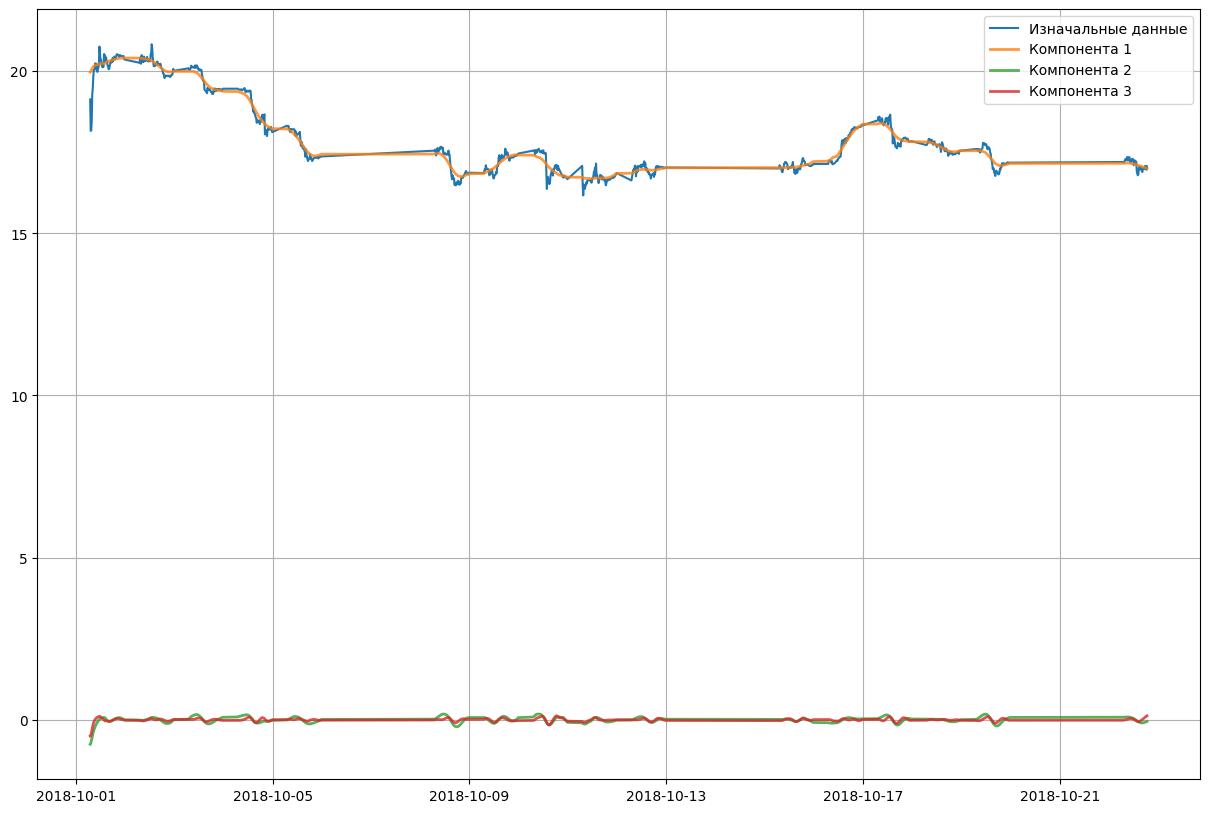

In [27]:
fig=plt.figure(figsize=(15, 10))
plt.plot(stock['close'], label='Изначальные данные')
plt.grid()

for idx in range(3):
    component = mssa.components_[0, :, idx]
    plt.plot(x.index, component, lw=2, alpha=0.8, label=f'Компонента {idx + 1}')

plt.legend()

In [29]:
mssa = MSSA(n_components=3,
            window_size=30,
            verbose=True)
x=temp['meantemp']
mssa.fit(x)

Constructing trajectory matrix
Trajectory matrix shape: (30, 1433)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


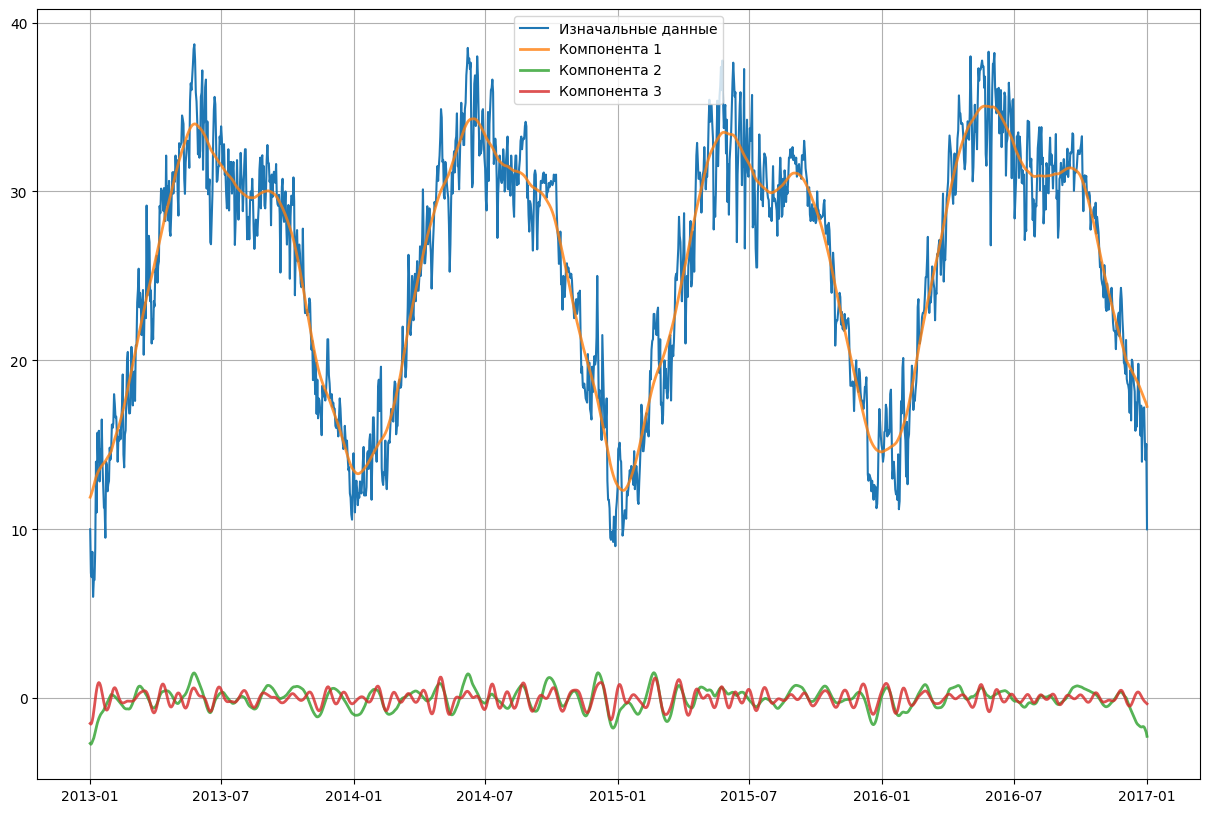

In [30]:
fig=plt.figure(figsize=(15, 10))
plt.plot(temp['meantemp'], label='Изначальные данные')
plt.grid()

for idx in range(3):
    component = mssa.components_[0, :, idx]
    plt.plot(x.index, component, lw=2, alpha=0.8, label=f'Компонента {idx + 1}')

plt.legend()

In [99]:
tp = 48
temp_te = temp.iloc[-tp:]
temp_tr = temp.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
x=temp_tr
mssa.fit(x)

Constructing trajectory matrix
Trajectory matrix shape: (707, 708)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 84 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


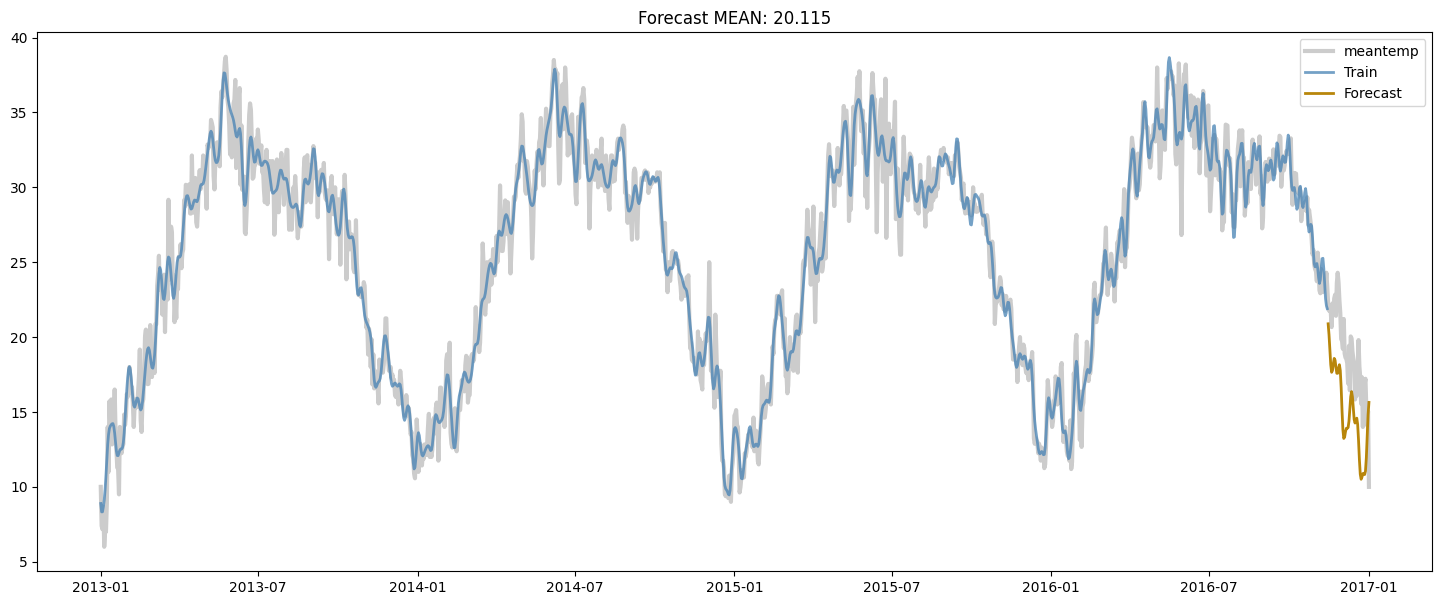

In [100]:
for ts_index in range(temp.shape[1]):
  tr = np.zeros(temp.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = temp_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(temp.index, temp.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=temp.columns[ts_index])
  ax.plot(temp.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(temp.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

In [101]:
tp = 48
stock_te = stock.iloc[-tp:]
stock_tr = stock.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
x=stock_tr
mssa.fit(x)

Constructing trajectory matrix
Trajectory matrix shape: (476, 477)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 57 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


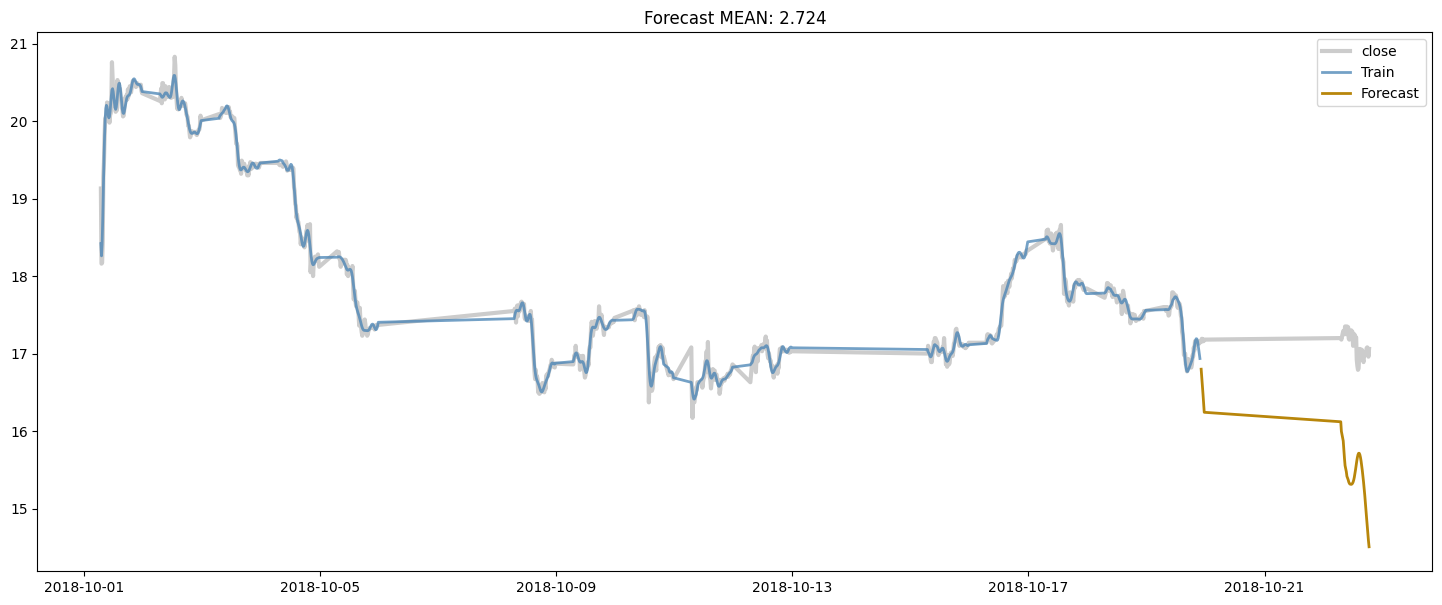

In [102]:
for ts_index in range(stock.shape[1]):
  tr = np.zeros(stock.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = stock_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(stock.index, stock.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=stock.columns[ts_index])
  ax.plot(stock.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(stock.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

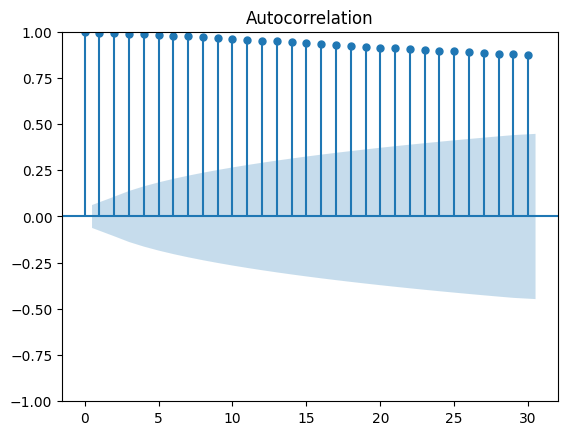

In [122]:
# Построение графика автокорреляционной функции
plot_acf(stock['close'].values)
plt.show()

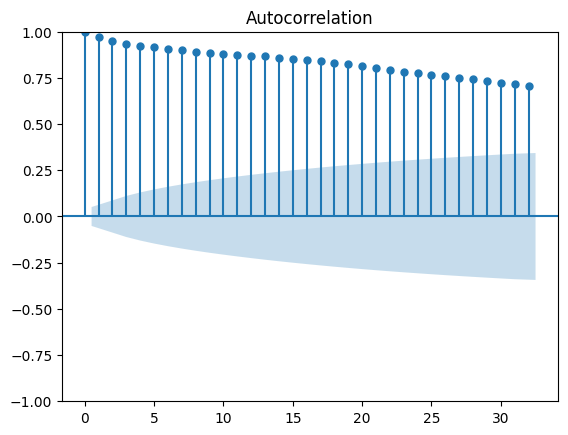

In [123]:
# Построение графика автокорреляционной функции
plot_acf(temp['meantemp'].values)
plt.show()

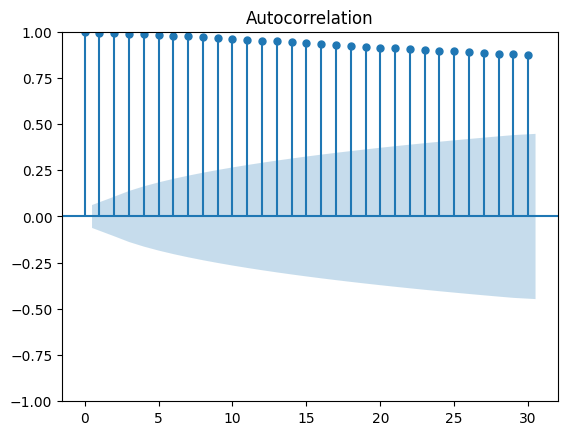